# Calculating inter-model spreads in CMIP5 variables
E Boland 2021 - contact emmomp@bas.ac.uk for any issues

This notebook is designed to access the JASMIN CMIP5 holdings and calculate inter-model spreads and standard deviations in a given variable. 

Requires baspy to access the CMIP5 holdings, accessible here: https://github.com/scotthosking/baspy

Options: 
- to include all runs, or only one per model, or one per modelling centre. 
- choose experiment
- choose time span

**N.B.** If choosing a 3D variable, or long time span/lots of models, you will probably need to export to an executable and run on the sci machines or LOTUS queue
I recommend trying out a subset in the notebook first to check the results are as expected

### Setting up 

In [1]:
import sys
sys.path.insert(0,'/home/users/eboland/python')
import baspy as bp
import xarray as xr
import pyresample
import numpy as np
import matplotlib.pyplot as plt

save_dir='../data_out' #edit this to where you want result files saved
plots_dir='../plots'

### Defining functions to re-grid the model data

Note that these default to re-gridding everything to a 1 degree x 1 degree grid, but also take new_lat and new_lon as arguments if you want a different (regular) grid

In [2]:
#Function to get re-gridding kernel for applying at each timestep
def setup_regrid(old_lat,old_lon,new_lat=np.linspace(-89.5,89.5,180),new_lon=np.linspace(-179,180,360)):
    orig_grid = pyresample.geometry.SwathDefinition(lons=old_lon.ravel(), lats=old_lat.ravel())
    yi,xi=np.meshgrid(new_lat,new_lon)
    new_grid  = pyresample.geometry.GridDefinition(lons=xi,lats=yi)
    resample_data = pyresample.kd_tree.get_neighbour_info(orig_grid, new_grid, 200000, neighbours=1)
    return resample_data   
#Function to apply re-gridding kernel for given timestep, return as xarray dataarray
def repeat_regrid(ds,resample_data,timestep, new_lat=np.linspace(-89.5,89.5,180),new_lon=np.linspace(-179,180,360)):    
    grid_shape=[new_lon.size,new_lat.size]
    foo = pyresample.kd_tree.get_sample_from_neighbour_info('nn', grid_shape, ds.ravel(),
                                              resample_data[0], resample_data[1],resample_data[2])    
    ds2=xr.DataArray(foo.T[:,:,None],dims=['lat','lon','time'],coords={'lon':(('lon'),new_lon),'lat':(('lat'),new_lat),'time':(('time'),[timestep])})
    return ds2

### 1. Choose the variable, experiment, and time span you want

In [4]:
#vars=['thetao','so','hfds','tauuo','tauvo']
var='hfds'
experiment='historical' #or rcp45 etc
time_start='1992-01-01' # In format 'YYYY-MM-DD' or None for the start/end
time_end=None

# If variable is 3D, specify depth levels as 'all' or list of depths, nearest depth levels will be used 
# leave as None for 2D
depths=[0,]

### 2. Load all ensemble members, or only first

In [5]:
#runs='all' # all runs available
runs='one' # loads only run r1i1p1 

if runs == 'all':
    print('Finding all runs for {} in {} experiment'.format(var,experiment))
    df = bp.catalogue(dataset='cmip5',Experiment=experiment,Var=var) #All models, all centres, all ensemble members:
    dim_id='model_run' #New dimension model_run will be created to calculate spreads/std devs
elif runs=='one' :
    print('Finding run r1i1p1 for {} in {} experiment'.format(var,experiment))
    df = bp.catalogue(dataset='cmip5',Experiment=experiment,Var=var,RunID='r1i1p1') # Only one ensemble per model
    dim_id = 'model'
else:
    print('Please set runs to "all" or "one"') 
models=set(df.Model)
centres=set(df.Centre)
print('Found {} sets of data from {} models from {} centres'.format(len(df),len(models),len(centres)))

Finding run r1i1p1 for hfds in historical experiment
Updating cached catalogue...
catalogue memory usage (MB): 28.774587
>> Current cached values (can be extended by specifying additional values or by setting read_everything=True) <<
{'Experiment': ['piControl', 'rcp85', 'rcp26', 'rcp45', 'historical'], 'Frequency': ['mon']}

Found 28 sets of data from 28 models from 15 centres


### 2.a. (optional) Subset models further
Choose only one model per centre, comment out this cell to keep all models

In [34]:
model_list=[]
for centre in centres:
    df_subset=df.loc[df['Centre']==centre]
    model_subset=set(df_subset.Model)
    #choose one
    foo=model_subset.pop()
    model_list.append(foo)
df=df.loc[df['Model'].isin(model_list)]
models=set(df.Model)
centres=set(df.Centre)
print('Found {} sets of data from {} models from {} centres'.format(len(df),len(models),len(centres)))

Found 21 sets of data from 21 models from 21 centres


### 3. Get data from each model, regridding as you go

In [8]:
data_all=[]

for index,row in df.iterrows():
    model=row['Model']
    centre=row['Centre']
    run=row['RunID']
    
    try:
        files=bp.get_files(row)
    except ValueError:
        print('{} {} {} throwing value error on listing files'.format(centre,model,run))  
        files=['/badc/cmip5/data/cmip5/output1'+row.Path+'/'+row['DataFiles'].split(';')[0],] #Fix for EC-EARTH double netcdf files
        
    print('{} {} {} Found {} files'.format(centre,model,run,len(files)))
    
    if model == 'FGOALS-g2':
        data=xr.open_mfdataset(files,decode_times=False)
        data['time']=data['time'].assign_attrs({'units':data['time'].units+'-01'}) #Fix for time units
        data=xr.decode_cf(data)
    else :   
        data=xr.open_mfdataset(files)
        
    #Subset by time
    data=data.sel(time=slice(time_start,time_end))

    #subset by depth, if present
    if 'lev' in data.variables:
        if depths == 'all':
            print('Keeping all depths')
        elif isinstance(depths, list):
            data=data.sel(lev=depths,method='nearest')
        else:
            raise ValueError('Depth dimension found. Please give depths as list of values or set to ''all''')
        
    old_lat=data['lat']
    old_lon=data['lon']
    #Put 1d lat/lon on a grid
    if old_lat.ndim==1:
        old_lat,old_lon=np.meshgrid(old_lat,old_lon)
    else:
        old_lat=old_lat.data
        old_lon=old_lon.data
    #Make sure all lons lie in -180 to +180
    old_lon=xr.where(old_lon>180,old_lon-360,old_lon)
    old_lon=xr.where(old_lon<-180,old_lon+360,old_lon)
       
    nt=len(data['time'])
    if str(data['time'].dtype).startswith('datetime64'):
        time_index=data.indexes['time']
    else: #Replace cf time data with numpy datetime
        time_index=data.indexes['time'].to_datetimeindex()
       
    print('Found data, proceeding to re-grid to 1 deg by 1 deg')
    resample_data=setup_regrid(old_lat,old_lon) # Generate re-gridding kernel
    data_1deg=[]
      
    for tstep in range(0,nt):      
        if np.mod(tstep,50)==0:
            print('Step {} of {}'.format(tstep,nt))
        data_in=data[var].isel(time=tstep)
        if old_lon.shape == data_in.shape:
            data_in = data_in.values
        else: 
            data_in = data_in.values.T
        
        #Catch for sign of windstress data
        if (var == ['tauuo','tauvo']) and (centre in ['NCAR','NSF-DOE-NCAR']):
            data_in = -data_in
        
        data_1deg.append(repeat_regrid(data_in,resample_data,time_index[tstep]))

    data_1deg=xr.combine_nested(data_1deg,concat_dim='time')
    data_1deg.attrs.update(data[var].attrs)
    
    print('Regridding complete')
    if runs == 'all':
        data_1deg=data_1deg.assign_coords({'model_run':model+'_'+run})
    else :
        data_1deg=data_1deg.assign_coords({'model':model,'run':run})
    data_all.append(data_1deg)

data_all=xr.combine_nested(data_all,concat_dim=dim_id,combine_attrs='drop_conflicts')
keys=list(data_all.attrs.keys())
for attr in keys:
    if attr not in ['long_name','units']: #Only keep listed attributes
        del data_all.attrs[attr]
data_all.attrs.update({'name':var})
        
print('All regridding complete')

BCC bcc-csm1-1-m r1i1p1 Found 1 files


<ipython-input-8-cd8ea54d976f>:51: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  time_index=data.indexes['time'].to_datetimeindex()


Found data, proceeding to re-grid to 1 deg by 1 deg
Step 0 of 252
Step 50 of 252
Step 100 of 252
Step 150 of 252
Step 200 of 252
Step 250 of 252
Regridding complete
BCC bcc-csm1-1 r1i1p1 Found 1 files


<ipython-input-8-cd8ea54d976f>:51: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  time_index=data.indexes['time'].to_datetimeindex()


Found data, proceeding to re-grid to 1 deg by 1 deg
Step 0 of 252
Step 50 of 252
Step 100 of 252
Step 150 of 252
Step 200 of 252
Step 250 of 252
Regridding complete
BNU BNU-ESM r1i1p1 Found 1 files


<ipython-input-8-cd8ea54d976f>:51: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  time_index=data.indexes['time'].to_datetimeindex()


Found data, proceeding to re-grid to 1 deg by 1 deg
Step 0 of 168
Step 50 of 168
Step 100 of 168
Step 150 of 168
Regridding complete
CMCC CMCC-CESM r1i1p1 Found 26 files
Found data, proceeding to re-grid to 1 deg by 1 deg
Step 0 of 168
Step 50 of 168
Step 100 of 168
Step 150 of 168
Regridding complete
CMCC CMCC-CM r1i1p1 Found 16 files
Found data, proceeding to re-grid to 1 deg by 1 deg
Step 0 of 168
Step 50 of 168
Step 100 of 168
Step 150 of 168
Regridding complete
CMCC CMCC-CMS r1i1p1 Found 16 files
Found data, proceeding to re-grid to 1 deg by 1 deg
Step 0 of 168
Step 50 of 168
Step 100 of 168
Step 150 of 168
Regridding complete
CNRM-CERFACS CNRM-CM5-2 r1i1p1 Found 16 files
Found data, proceeding to re-grid to 1 deg by 1 deg
Step 0 of 168
Step 50 of 168
Step 100 of 168
Step 150 of 168
Regridding complete
CNRM-CERFACS CNRM-CM5 r1i1p1 Found 16 files
Found data, proceeding to re-grid to 1 deg by 1 deg
Step 0 of 168
Step 50 of 168
Step 100 of 168
Step 150 of 168
Regridding complete
CSIR

<ipython-input-8-cd8ea54d976f>:51: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  time_index=data.indexes['time'].to_datetimeindex()


Found data, proceeding to re-grid to 1 deg by 1 deg
Step 0 of 168
Step 50 of 168
Step 100 of 168
Step 150 of 168
Regridding complete
ICHEC EC-EARTH r1i1p1 Found 16 files
Found data, proceeding to re-grid to 1 deg by 1 deg
Step 0 of 169
Step 50 of 169
Step 100 of 169
Step 150 of 169
Regridding complete
INM inmcm4 r1i1p1 Found 1 files


<ipython-input-8-cd8ea54d976f>:51: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  time_index=data.indexes['time'].to_datetimeindex()


Found data, proceeding to re-grid to 1 deg by 1 deg
Step 0 of 168
Step 50 of 168
Step 100 of 168
Step 150 of 168
Regridding complete
LASG-CESS FGOALS-g2 r1i1p1 Found 4 files


<ipython-input-8-cd8ea54d976f>:51: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  time_index=data.indexes['time'].to_datetimeindex()


Found data, proceeding to re-grid to 1 deg by 1 deg
Step 0 of 168
Step 50 of 168
Step 100 of 168
Step 150 of 168
Regridding complete
MIROC MIROC-ESM-CHEM r1i1p1 Found 1 files
Found data, proceeding to re-grid to 1 deg by 1 deg
Step 0 of 168
Step 50 of 168
Step 100 of 168
Step 150 of 168
Regridding complete
MIROC MIROC-ESM r1i1p1 Found 1 files
Found data, proceeding to re-grid to 1 deg by 1 deg
Step 0 of 168
Step 50 of 168
Step 100 of 168
Step 150 of 168
Regridding complete
MIROC MIROC4h r1i1p1 Found 7 files
Found data, proceeding to re-grid to 1 deg by 1 deg
Step 0 of 168
Step 50 of 168
Step 100 of 168
Step 150 of 168
Regridding complete
MIROC MIROC5 r1i1p1 Found 1 files


<ipython-input-8-cd8ea54d976f>:51: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  time_index=data.indexes['time'].to_datetimeindex()


Found data, proceeding to re-grid to 1 deg by 1 deg
Step 0 of 252
Step 50 of 252
Step 100 of 252
Step 150 of 252
Step 200 of 252
Step 250 of 252
Regridding complete
MPI-M MPI-ESM-LR r1i1p1 Found 1 files
Found data, proceeding to re-grid to 1 deg by 1 deg
Step 0 of 168
Step 50 of 168
Step 100 of 168
Step 150 of 168
Regridding complete
MPI-M MPI-ESM-MR r1i1p1 Found 3 files
Found data, proceeding to re-grid to 1 deg by 1 deg
Step 0 of 168
Step 50 of 168
Step 100 of 168
Step 150 of 168
Regridding complete
MPI-M MPI-ESM-P r1i1p1 Found 1 files


/home/users/eboland/.conda/envs/nbenvconda/lib/python3.9/site-packages/xarray/coding/times.py:117: SerializationWarning: Ambiguous reference date string: 850-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0850-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


Found data, proceeding to re-grid to 1 deg by 1 deg
Step 0 of 168
Step 50 of 168
Step 100 of 168
Step 150 of 168
Regridding complete
MRI MRI-CGCM3 r1i1p1 Found 1 files
Found data, proceeding to re-grid to 1 deg by 1 deg
Step 0 of 168
Step 50 of 168
Step 100 of 168
Step 150 of 168
Regridding complete
MRI MRI-ESM1 r1i1p1 Found 1 files
Found data, proceeding to re-grid to 1 deg by 1 deg
Step 0 of 168
Step 50 of 168
Step 100 of 168
Step 150 of 168
Regridding complete
NASA-GISS GISS-E2-R-CC r1i1p1 Found 7 files


<ipython-input-8-cd8ea54d976f>:51: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  time_index=data.indexes['time'].to_datetimeindex()


Found data, proceeding to re-grid to 1 deg by 1 deg
Step 0 of 228
Step 50 of 228
Step 100 of 228
Step 150 of 228
Step 200 of 228
Regridding complete
NASA-GISS GISS-E2-R r1i1p1 Found 7 files


<ipython-input-8-cd8ea54d976f>:51: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  time_index=data.indexes['time'].to_datetimeindex()


Found data, proceeding to re-grid to 1 deg by 1 deg
Step 0 of 168
Step 50 of 168
Step 100 of 168
Step 150 of 168
Regridding complete
NCC NorESM1-M r1i1p1 Found 1 files


<ipython-input-8-cd8ea54d976f>:51: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  time_index=data.indexes['time'].to_datetimeindex()


Found data, proceeding to re-grid to 1 deg by 1 deg
Step 0 of 168
Step 50 of 168
Step 100 of 168
Step 150 of 168
Regridding complete
NCC NorESM1-ME r1i1p1 Found 1 files


<ipython-input-8-cd8ea54d976f>:51: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  time_index=data.indexes['time'].to_datetimeindex()


Found data, proceeding to re-grid to 1 deg by 1 deg
Step 0 of 168
Step 50 of 168
Step 100 of 168
Step 150 of 168
Regridding complete
NOAA-GFDL GFDL-ESM2G r1i1p1 Found 29 files


<ipython-input-8-cd8ea54d976f>:51: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  time_index=data.indexes['time'].to_datetimeindex()


Found data, proceeding to re-grid to 1 deg by 1 deg
Step 0 of 168
Step 50 of 168
Step 100 of 168
Step 150 of 168
Regridding complete
All regridding complete


### 4. Plot regridded models to spot any issues

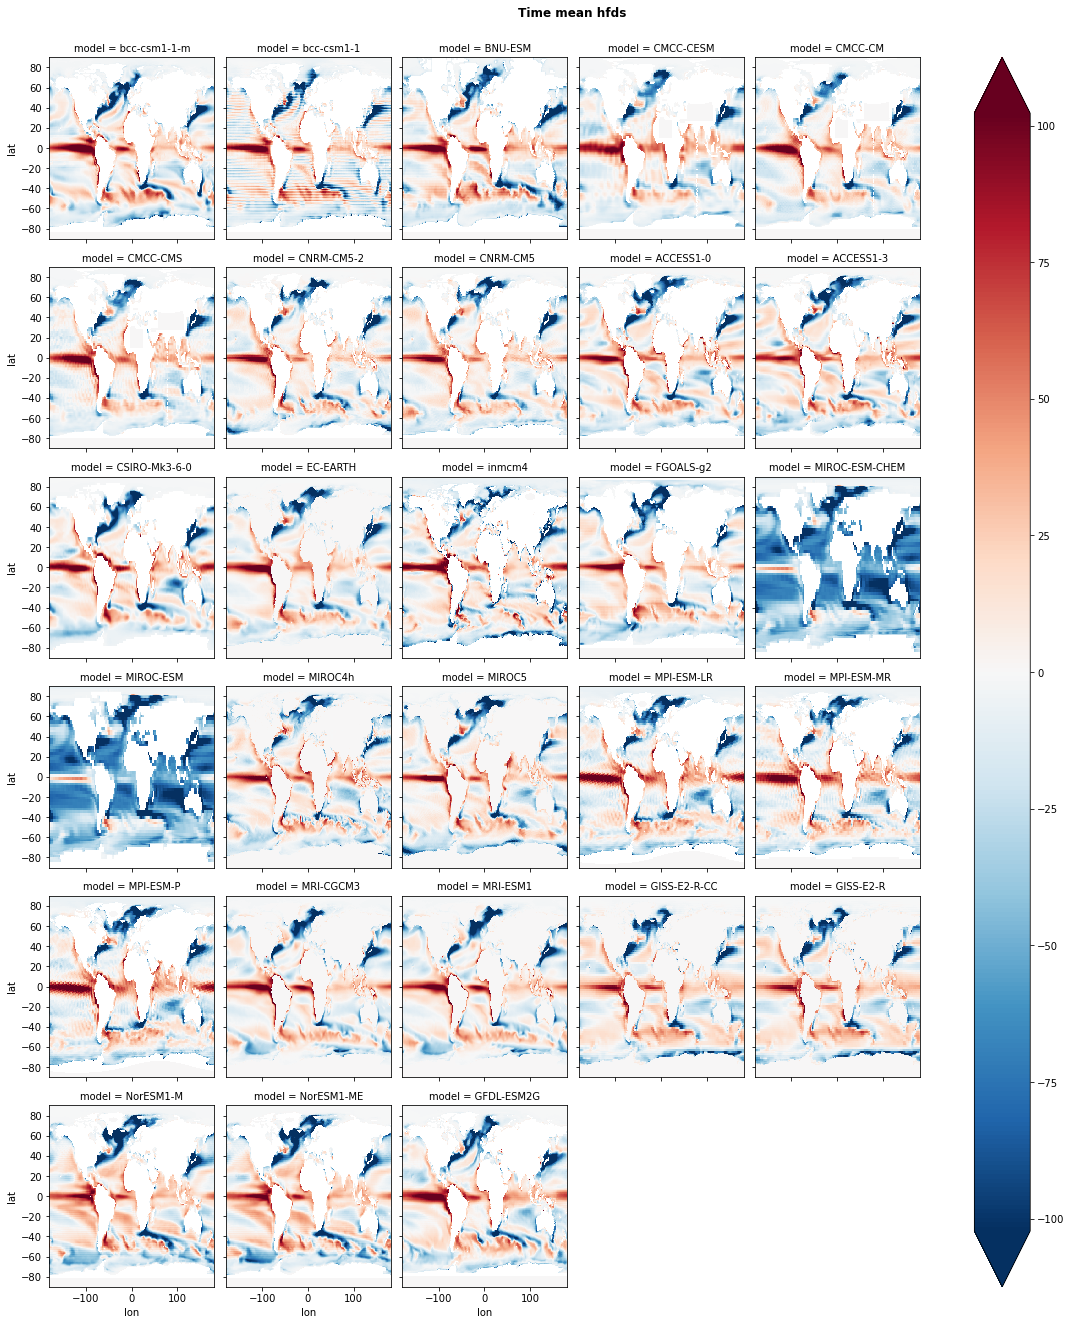

In [9]:
data_all.mean(dim=['time']).plot(x='lon',y='lat',col=dim_id,col_wrap=5,robust=True)
plt.suptitle('Time mean {}'.format(var),y=1.02,fontweight='bold')
plt.savefig(plot_dir+'/cmip5_time_mean_'+var+'_modelthumbnails.png')

### 5. Calculate and save model spread and model std-deviations

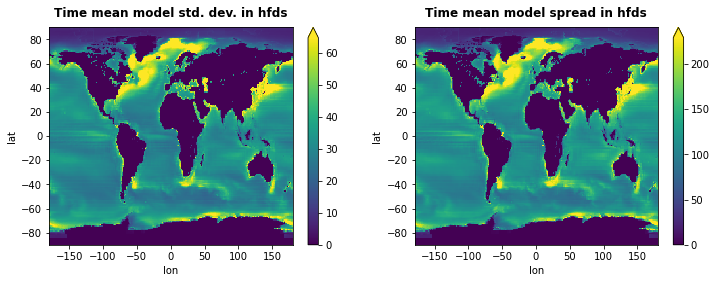

In [11]:
model_std = data_all.std(dim=dim_id)
model_std.attrs['units']=data_all.attrs['units']
model_std.attrs['name']='stddev_'+data_all.attrs['name']
model_std.attrs['long_name']='Ensemble Standard Deviation of '+data_all.attrs['long_name']
model_std.attrs['comments']='Calculated for models listed'

model_spread = data_all.max(dim=dim_id)-data_all.min(dim=dim_id)
model_spread.attrs['units']=data_all.attrs['units']
model_spread.attrs['name']='spread_'+data_all.attrs['name']
model_spread.attrs['long_name']='Ensemble Spread of '+data_all.attrs['long_name']
model_std.attrs['comments']='Calculated for models listed'

dataset_out = xr.Dataset(data_vars={'model_std':model_std,'model_spread':model_spread,'models':data_all['model']})
dataset_out.attrs['comments']='Generated on '+str(np.datetime64('today'))
dataset_out.to_netcdf((save_dir+'/cmip5_stdspread_{}_{}.nc').format(var,dim_id))

fig=plt.figure(figsize=[12,4])
ax=plt.subplot(1,2,1)
model_std.mean(dim='time').plot(x='lon',y='lat',robust=True,ax=ax)
ax.set_title('Time mean model std. dev. in {}'.format(var),y=1.02,fontweight='bold')     

ax=plt.subplot(1,2,2)
model_spread.mean(dim='time').plot(x='lon',y='lat',robust=True,ax=ax)
ax.set_title('Time mean model spread in {}'.format(var),y=1.02,fontweight='bold')   
plt.savefig(plot_dir+'/cmip5_stdspread_{}_{}.png'.format(var,dim_id))

## 6. Convert to python executable [optional]

In [1]:
!jupyter nbconvert --to script CMIP5_ranges.ipynb

[NbConvertApp] Converting notebook CMIP5_ranges.ipynb to script
[NbConvertApp] Writing 9222 bytes to CMIP5_ranges.py
